In [219]:
import os
import sys
import copy
import logging
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.datasets import fetch_california_housing, make_regression
sys.path.insert(0, 'C:\\Users\\Utente\\Desktop\\Dev\\Progetti\\OrderAi\\Models\\components\\')
from Layer import Layer
import AdamMB

#housing = fetch_california_housing()
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
k = 5
epochs = 5000
lr = 0.01
batch_size = 250

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(housing.data, housing.target, test_size=0.98, random_state=2)
XR, yR = make_regression(n_samples=3000, n_features=2, noise=10, random_state=5)
X_train2, X_test2, y_train2, y_test2 = train_test_split(XR, yR, test_size=0.20, random_state=2)

def normalize_dataset(X):
    return tf.keras.utils.normalize(X)

def make_dataset(X_data,y_data,k):
    def gen():
        for train_index, test_index in KFold(k).split(X_data):
            X_train, X_test = X_data[train_index], X_data[test_index]
            XN_train, XN_test = normalize_dataset(X_data[train_index]), normalize_dataset(X_data[test_index])
            y_train, y_test = y_data[train_index], y_data[test_index]
            yield X_train,XN_train,y_train,X_test,XN_test,y_test

    return tf.data.Dataset.from_generator(gen, (tf.double,tf.double,tf.double,tf.double,tf.double,tf.double))
    
dataset = make_dataset(X_train_b, y_train_b, k)

In [220]:
class MLPLinearRegressor(tf.Module):
    def __init__(self, layers, k, epochs=100, lr=0.01, batch_size=50):
        self.layers = layers
        self.epochs = epochs
        self.batch_size = batch_size
        self.batch_counter = 0
        self.learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps=1000000, decay_rate=0.96, staircase=True)
        self.optimizer = tf.keras.optimizers.Adam(self.learning_rate)
        self.train_mse = tf.keras.metrics.MeanSquaredError()
        self.train_mae = tf.keras.metrics.MeanAbsoluteError()
        self.train_accuracy = tf.keras.metrics.MeanSquaredLogarithmicError()
        self.test_mse = tf.keras.metrics.MeanSquaredError()
        self.test_mae = tf.keras.metrics.MeanAbsoluteError()
        self.test_accuracy = tf.keras.metrics.MeanSquaredLogarithmicError()
        self.regularizer = tf.keras.layers.ActivityRegularization()
        self.loss_history = [e for e in range(epochs*k)]
        self.bias_history = [e for e in range(epochs*k)]
        self.mae_train_error_history = [e for e in range(epochs*k)]
        self.mse_train_error_history = [e for e in range(epochs*k)]
        self.mae_test_error_history = [e for e in range(epochs*k)]
        self.mse_test_error_history = [e for e in range(epochs*k)]
        self.residual_tr = [e for e in range(epochs*k)]
        self.residual_tt = [e for e in range(epochs*k)]
        self.r2_accuracy_tr = [e for e in range(epochs*k)]
        self.r2_accuracy_tt = [e for e in range(epochs*k)]
        self.loaded = False

    def reset_history_metrics(self):
        self.train_mse.reset_state()
        self.train_mae.reset_state()
        self.test_mse.reset_state()
        self.test_mae.reset_state()
    
    def update_states(self, loss, i, y, y_test):
        self.bias_history[i] = self.bias
        self.loss_history[i] = loss.numpy()
        self.mae_train_error_history[i] = self.train_mae.result().numpy()
        self.mse_train_error_history[i] = self.train_mse.result().numpy()
        self.mae_test_error_history[i] = self.test_mae.result().numpy()
        self.mse_test_error_history[i] = self.test_mse.result().numpy()
        self.r2_accuracy_tr[i] = self.r2(y, self.predicted_train)
        self.r2_accuracy_tt[i] = self.r2(y_test, self.predicted_test)
        self.residual_tr[i] = tf.reduce_mean(tf.subtract(y, self.predicted_train))
        self.residual_tt[i] = tf.reduce_mean(tf.subtract(y_test, self.predicted_test))

    def calc_metrics(self, y, y_test, e, k, loss):
        self.reset_history_metrics()
        self.train_mae.update_state(y, self.predicted_train)
        self.train_mse.update_state(y, self.predicted_train)
        self.test_mae.update_state(y_test, self.predicted_test)
        self.test_mse.update_state(y_test, self.predicted_test)
        self.update_states(loss, e+(k*self.epochs), y, y_test)

    def verify_batch(self, X, X_test):
        if self.batch_counter == X:
            self.batch_counter = 0
        
    def r2(self, y, y_pred):
        return tf.subtract(
            tf.convert_to_tensor(1, dtype=tf.float64), 
            tf.divide(
                tf.reduce_sum(tf.square(tf.subtract(y, y_pred))),
                tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y_pred))))
            )
        )

    @tf.function
    def lasso(self):
        lassos = [w for w in range(len(self.layers))]
        for w in range(len(self.layers)):
            lassos[w] = tf.reduce_sum(tf.norm(self.layers[w].weights))
        return tf.reduce_mean(lassos)

    @tf.function
    def ridge(self):
        ridges = [w for w in range(len(self.layers))]
        for w in range(len(self.layers)):
            ridges[w] = tf.reduce_sum(tf.square(tf.norm(self.layers[w].weights)))
        return tf.reduce_mean(ridges)

    @tf.function(reduce_retracing=True)
    def loss(self, y, predicted):
        return tf.add(tf.add(tf.losses.MSE(y, predicted), self.lasso()), 0)
        
    @tf.function(reduce_retracing=True)
    def _predict_train(self, X, weights):
        compressed_weights = tf.reduce_mean(tf.subtract(tf.multiply(X, weights), self.bias), axis=1)
        return tf.reduce_mean(tf.add(tf.multiply(tf.transpose(X), compressed_weights), self.bias), axis=1, name="Predict_Train")

    @tf.function
    def _predict(self, X_test, compressed_weights):
        return tf.reduce_mean(tf.add(tf.multiply(X_test, compressed_weights), self.bias), axis=1, name="Predict_Test")
    
    def predict(self, x):
        return tf.reduce_mean(tf.add(tf.multiply(x, self.compressed_weights), self.bias))

    @tf.function(reduce_retracing=True)
    def _forward(self, X):
        for layer in self.layers:
            X = layer(X)
        return X

    @tf.function(reduce_retracing=True)
    def _backprop(self, X, XN, X_test, y):
        batch_xn = XN[self.batch_counter:self.batch_counter+self.batch_size, :]
        weights = self._forward(batch_xn)
        self.bias = self.layers[len(self.layers)-1].bias

        compressed_weights = tf.reduce_mean(tf.add(tf.multiply(tf.transpose(batch_xn), tf.reduce_mean(weights, axis=0)), self.bias), axis=1)

        predicted_train = self._predict(X, compressed_weights)
        predicted_test = self._predict(X_test, compressed_weights)

        loss = tf.nn.scale_regularization_loss(self.loss(y, predicted_train))

        self.vars = [self.layers[0].weights, self.layers[1].weights, self.layers[2].weights,self.layers[3].weights,self.layers[4].weights, self.layers[0].bias, self.layers[1].bias, self.layers[2].bias,self.layers[3].bias,self.layers[4].bias]
        self.batch_counter = self.batch_counter + self.batch_size
        return loss, compressed_weights, predicted_train, predicted_test

    def run(self, X, X_test, XN, XN_test, y, y_test, k):
        for e in range(self.epochs):
            self.verify_batch(X.shape[0], X_test.shape[0])
            
            with tf.GradientTape(watch_accessed_variables=True, persistent=True) as tape:
                loss, self.compressed_weights, self.predicted_train, self.predicted_test = self._backprop(X, XN, X_test, y)
            
            grads = tape.gradient(loss, self.vars)  
            self.optimizer.apply_gradients(zip(grads, self.vars))   
            self.calc_metrics(y, y_test, e, k, loss)

kk = 1
model = MLPLinearRegressor([
    Layer(activation=tf.nn.relu),
    Layer(activation=tf.nn.relu),
    Layer(activation=tf.nn.relu),
    Layer(activation=tf.sigmoid),
    Layer()
], kk, epochs=epochs, lr=lr, batch_size=batch_size)


def run_model(data, model, X, XN, X_t, XN_t, y, y_t):
    k = 0
    #model.run(X, X_t, XN, XN_t, tf.squeeze(y), tf.squeeze(y_t))
    for data in dataset.as_numpy_iterator():
        X_train, XN_train, y_train, X_test, XN_test, y_test = data
        model.run(X_train, X_test, XN_train, XN_test, tf.squeeze(y_train), tf.squeeze(y_test), k)
        k = k+1
        break
    return X_train, X_test, XN_train, XN_test, tf.squeeze(y_train), tf.squeeze(y_test)
     
     
X_train, X_test, XN_train, XN_test, y_train, y_test = run_model(dataset, model, X_train2, normalize_dataset(X_train2), X_test2, normalize_dataset(X_test2), y_train2, y_test2)


Original:  86.98843005885753 
Predicted:  73.84910318525165 
Tested: 73.84910193607588 

Train_MeanSquaredError:  97.680115
Train_MeanAbsoluteError:  7.9298763
Train_MeanSquaredLogError:  0.0
Train_R2Accuracy:  0.9879063843219044
----- ---------------------------------------------------
Test_MeanSquaredError:  103.46464
Train_MeanAbsoluteError:  8.246868
Test_MeanSquaredLogError:  0.0
Train_R2Accuracy:  0.9867968104336003


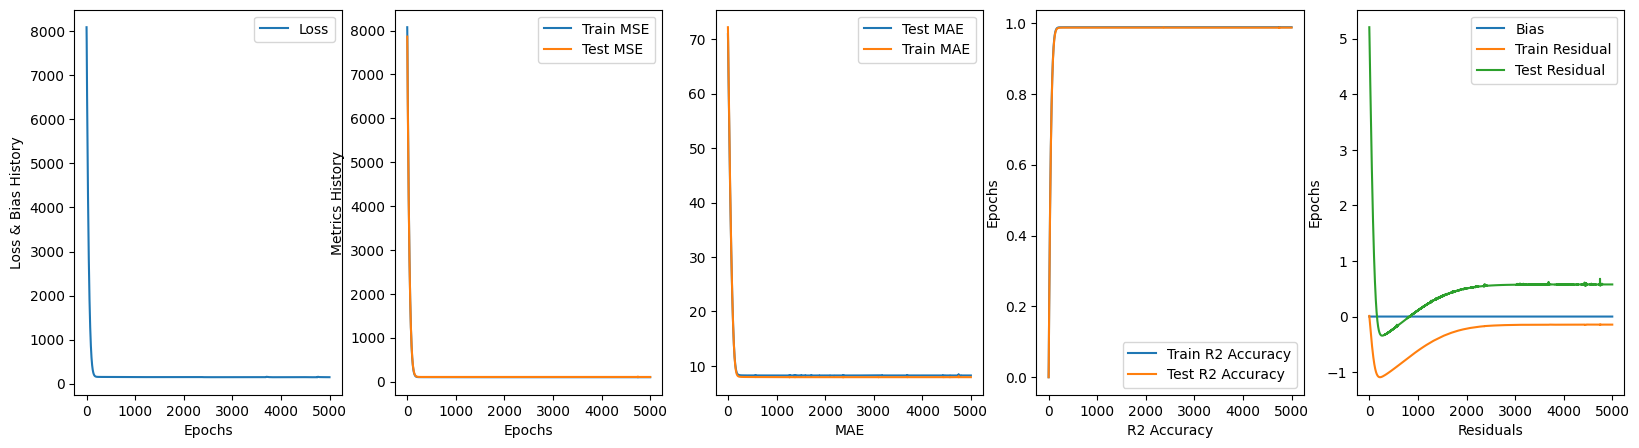

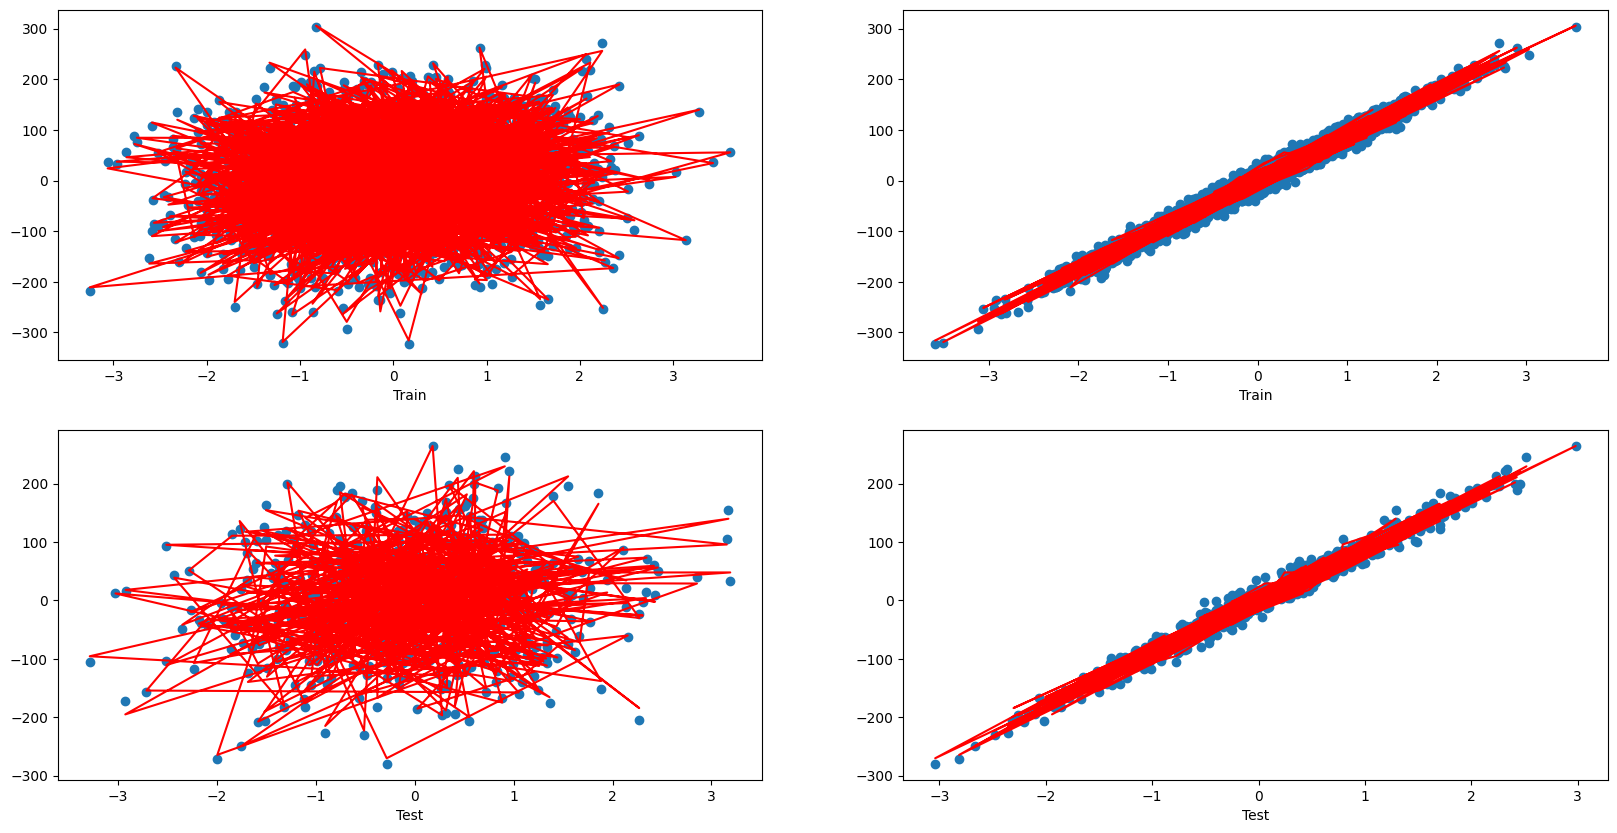

In [223]:
print("\nOriginal: ", y_test[0].numpy(), "\nPredicted: ", model.predict(X_test[0]).numpy(), "\nTested:", model.predicted_test[0].numpy(), "\n")
print("Train_MeanSquaredError: ", model.train_mse.result().numpy())
print("Train_MeanAbsoluteError: ", model.train_mae.result().numpy())
print("Train_MeanSquaredLogError: ", model.train_accuracy.result().numpy())
print("Train_R2Accuracy: ", model.r2_accuracy_tr[(epochs*kk)-1].numpy()) 
print('----- ---------------------------------------------------')
print("Test_MeanSquaredError: ", model.test_mse.result().numpy())
print("Train_MeanAbsoluteError: ", model.test_mae.result().numpy())
print("Test_MeanSquaredLogError: ", model.test_accuracy.result().numpy())
print("Train_R2Accuracy: ", model.r2_accuracy_tt[(epochs*kk)-1].numpy()) 

fig, ax = plt.subplots(1, 5, figsize=(20, 5))
ax[0].plot([e for e in range(epochs*kk)], model.loss_history, label="Loss")
ax[0].set_ylabel('Loss & Bias History')
ax[0].set_xlabel('Epochs')
ax[0].legend()

ax[1].plot([e for e in range(epochs*kk)], model.mse_train_error_history, label="Train MSE")
ax[1].plot([e for e in range(epochs*kk)], model.mse_test_error_history, label="Test MSE")
ax[1].set_ylabel('MSE')
ax[1].set_xlabel('Epochs')
ax[1].legend()

ax[4].plot([e for e in range(epochs*kk)], model.bias_history, label="Bias")
ax[4].plot([e for e in range(epochs*kk)], model.residual_tr, label="Train Residual")
ax[4].plot([e for e in range(epochs*kk)], model.residual_tt, label="Test Residual")
ax[4].set_xlabel('Residuals')
ax[4].set_ylabel('Epochs')
ax[4].legend()

ax[3].plot([e for e in range(epochs*kk)], model.r2_accuracy_tr, label="Train R2 Accuracy")
ax[3].plot([e for e in range(epochs*kk)], model.r2_accuracy_tt, label="Test R2 Accuracy")
ax[3].set_xlabel('R2 Accuracy')
ax[3].set_ylabel('Epochs')
ax[3].legend()

ax[2].plot([e for e in range(epochs*kk)], model.mae_test_error_history, label="Test MAE")
ax[2].plot([e for e in range(epochs*kk)], model.mae_train_error_history, label="Train MAE")
ax[2].set_ylabel('MAE')
ax[2].set_xlabel('Epochs')
ax[2].legend()

fig2, ax2 = plt.subplots(2, X_train.shape[1], figsize=(20, 10))


for i in range(X_train.shape[1]):
    if X_train.shape[1] == 1:
        ax2[0].scatter(X_train[:], y_train[:])
        ax2[0].plot(X_train[:], model.predicted_train[:], color='r')
        #ax2[0].set_ylim([-300, 300])
        #ax2[0].set_xlim(-3,3)
        ax2[0].set_xlabel("Train")

        ax2[1].scatter(X_test[:], y_test[:])
        ax2[1].plot(X_test[:], model.predicted_test[:], color='r')
        #ax2[1].set_ylim([-200, 200])
        #ax2[1].set_xlim(-3,3)
        ax2[1].set_xlabel("Test")
    else:
        ax2[0, i].scatter(X_train[:, i], y_train[:])
        ax2[0, i].plot(X_train[:, i], model.predicted_train[:], color='r')
        #ax2[0, i].set_ylim([-300, 300])
        #ax2[0, i].set_xlim(-3,3)
        ax2[0, i].set_xlabel("Train")

        ax2[1, i].scatter(X_test[:, i], y_test[:])
        ax2[1, i].plot(X_test[:, i], model.predicted_test[:], color='r')
        #ax2[1, i].set_ylim([-200, 200])
        #ax2[1, i].set_xlim(-3,3)
        ax2[1, i].set_xlabel("Test")

"""
fig3d = plt.figure()
ax3d = fig3d.add_subplot(projection='3d')
ax3d.scatter(X_train[:, 0], X_train[:, 1], y_train[:])
ax3d.plot(X_train[:, 0], X_train[:, 1], model.predicted_train[:], color='r')"""


plt.show()
